# MLP 219
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=2
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP219'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP219.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5499 - accuracy: 0.7168 - val_loss: 0.5036 - val_accuracy: 0.7654
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5122 - accuracy: 0.7506 - val_loss: 0.4830 - val_accuracy: 0.7604
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5045 - accuracy: 0.7570 - val_loss: 0.4828 - val_accuracy: 0.7579
Epoch 4/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4992 - accuracy: 0.7606 - val_loss: 0.4766 - val_accuracy: 0.7666
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5009 - accuracy: 0.7613 - val_loss: 0.4912 - val_accuracy: 0.7666
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4982 - accuracy: 0.7617 - val_loss: 0.4805 - val_accuracy: 0.7647
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4947 - accuracy: 0.764

Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4529 - accuracy: 0.7884 - val_loss: 0.4529 - val_accuracy: 0.7846
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4528 - accuracy: 0.7926 - val_loss: 0.4384 - val_accuracy: 0.7908
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4516 - accuracy: 0.7905 - val_loss: 0.4475 - val_accuracy: 0.7883
Epoch 52/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4516 - accuracy: 0.7908 - val_loss: 0.4425 - val_accuracy: 0.7914
Epoch 53/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4523 - accuracy: 0.7904 - val_loss: 0.4376 - val_accuracy: 0.7983
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4520 - accuracy: 0.7910 - val_loss: 0.4387 - val_accuracy: 0.7983
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4490 - accuracy: 0.7909 - val_loss: 0.4369 - val_accuracy:

Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4441 - accuracy: 0.7947 - val_loss: 0.4442 - val_accuracy: 0.7945
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4421 - accuracy: 0.7953 - val_loss: 0.4354 - val_accuracy: 0.7927
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4442 - accuracy: 0.7923 - val_loss: 0.4368 - val_accuracy: 0.7976
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4425 - accuracy: 0.7951 - val_loss: 0.4389 - val_accuracy: 0.7945
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4421 - accuracy: 0.7928 - val_loss: 0.4332 - val_accuracy: 0.7945
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4437 - accuracy: 0.7947 - val_loss: 0.4463 - val_accuracy: 0.7883
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4415 - accuracy: 0.7953 - val_loss: 0.4484 - val_ac

453/453 [==============================] - 1s 3ms/step - loss: 0.4385 - accuracy: 0.7979 - val_loss: 0.4307 - val_accuracy: 0.7939
Epoch 160/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4356 - accuracy: 0.7993 - val_loss: 0.4315 - val_accuracy: 0.7933
Epoch 161/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4365 - accuracy: 0.7998 - val_loss: 0.4297 - val_accuracy: 0.8020
Epoch 162/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4365 - accuracy: 0.7980 - val_loss: 0.4275 - val_accuracy: 0.8007
Epoch 163/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4368 - accuracy: 0.7976 - val_loss: 0.4339 - val_accuracy: 0.8007
Epoch 164/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4366 - accuracy: 0.7995 - val_loss: 0.4338 - val_accuracy: 0.7958
Epoch 165/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4358 - accuracy: 0.7963 - val_loss: 0.4288 - val_accuracy: 0.8032

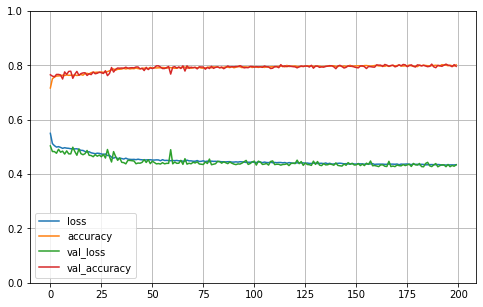

accuracy: 80.45%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5380 - accuracy: 0.7277 - val_loss: 0.5393 - val_accuracy: 0.7461
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5125 - accuracy: 0.7466 - val_loss: 0.5004 - val_accuracy: 0.7635
Epoch 3/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5029 - accuracy: 0.7605 - val_loss: 0.5006 - val_accuracy: 0.7709
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4988 - accuracy: 0.7609 - val_loss: 0.5027 - val_accuracy: 0.7654
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4985 - accuracy: 0.7613 - val_loss: 0.5235 - val_accuracy: 0.7542
Epoch 6/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4964 - accuracy: 0.7624 - val_loss: 0.4955 - val_accuracy: 0.7753
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4931 - accuracy: 0.76

Epoch 46/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4501 - accuracy: 0.7882 - val_loss: 0.4550 - val_accuracy: 0.7790
Epoch 47/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4466 - accuracy: 0.7915 - val_loss: 0.4555 - val_accuracy: 0.7908
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4490 - accuracy: 0.7893 - val_loss: 0.4864 - val_accuracy: 0.7778
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4468 - accuracy: 0.7896 - val_loss: 0.4594 - val_accuracy: 0.7983
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4495 - accuracy: 0.7891 - val_loss: 0.4561 - val_accuracy: 0.7945
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4474 - accuracy: 0.7911 - val_loss: 0.4581 - val_accuracy: 0.7933
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.7903 - val_loss: 0.4534 - val_accuracy:

453/453 [==============================] - 1s 2ms/step - loss: 0.4379 - accuracy: 0.7951 - val_loss: 0.4514 - val_accuracy: 0.7989
Epoch 101/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4388 - accuracy: 0.7962 - val_loss: 0.4583 - val_accuracy: 0.7927
Epoch 102/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4399 - accuracy: 0.7960 - val_loss: 0.4522 - val_accuracy: 0.7902
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4389 - accuracy: 0.7984 - val_loss: 0.4569 - val_accuracy: 0.7945
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4366 - accuracy: 0.7957 - val_loss: 0.4489 - val_accuracy: 0.8001
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4373 - accuracy: 0.7976 - val_loss: 0.4496 - val_accuracy: 0.7939
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.7982 - val_loss: 0.4531 - val_accuracy: 0.7896

453/453 [==============================] - 1s 2ms/step - loss: 0.4301 - accuracy: 0.8002 - val_loss: 0.4465 - val_accuracy: 0.7890
Epoch 156/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4337 - accuracy: 0.7990 - val_loss: 0.4569 - val_accuracy: 0.7834
Epoch 157/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4321 - accuracy: 0.7976 - val_loss: 0.4481 - val_accuracy: 0.7921
Epoch 158/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4314 - accuracy: 0.8002 - val_loss: 0.4586 - val_accuracy: 0.8007
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4314 - accuracy: 0.8011 - val_loss: 0.4459 - val_accuracy: 0.7970
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4325 - accuracy: 0.7994 - val_loss: 0.4551 - val_accuracy: 0.7927
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4325 - accuracy: 0.8020 - val_loss: 0.4469 - val_accuracy: 0.7939

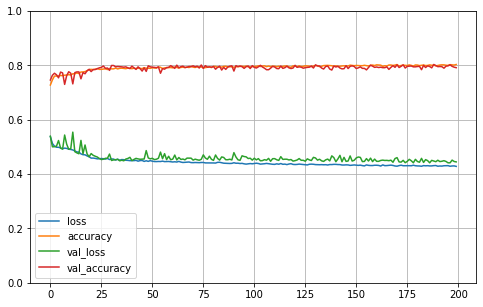

accuracy: 80.32%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5448 - accuracy: 0.7232 - val_loss: 0.5099 - val_accuracy: 0.7592
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5125 - accuracy: 0.7513 - val_loss: 0.5043 - val_accuracy: 0.7548
Epoch 3/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5027 - accuracy: 0.7590 - val_loss: 0.5152 - val_accuracy: 0.7623
Epoch 4/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4991 - accuracy: 0.7601 - val_loss: 0.4983 - val_accuracy: 0.7728
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4970 - accuracy: 0.7619 - val_loss: 0.4819 - val_accuracy: 0.7747
Epoch 6/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5011 - accuracy: 0.7625 - val_loss: 0.4971 - val_accuracy: 0.7784
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4946 - accuracy: 0.76

453/453 [==============================] - 1s 3ms/step - loss: 0.4500 - accuracy: 0.7892 - val_loss: 0.4486 - val_accuracy: 0.7964
Epoch 46/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4507 - accuracy: 0.7882 - val_loss: 0.4508 - val_accuracy: 0.7952
Epoch 47/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4516 - accuracy: 0.7894 - val_loss: 0.4503 - val_accuracy: 0.7939
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4506 - accuracy: 0.7884 - val_loss: 0.4500 - val_accuracy: 0.7970
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4497 - accuracy: 0.7891 - val_loss: 0.4487 - val_accuracy: 0.7983
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4501 - accuracy: 0.7893 - val_loss: 0.4514 - val_accuracy: 0.7945
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4503 - accuracy: 0.7884 - val_loss: 0.4554 - val_accuracy: 0.7976
Epoch

453/453 [==============================] - 1s 3ms/step - loss: 0.4424 - accuracy: 0.7947 - val_loss: 0.4457 - val_accuracy: 0.8038
Epoch 100/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4403 - accuracy: 0.7967 - val_loss: 0.4483 - val_accuracy: 0.7976
Epoch 101/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4408 - accuracy: 0.7942 - val_loss: 0.4488 - val_accuracy: 0.7958
Epoch 102/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4418 - accuracy: 0.7942 - val_loss: 0.4576 - val_accuracy: 0.7902
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4420 - accuracy: 0.7951 - val_loss: 0.4545 - val_accuracy: 0.7908
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4406 - accuracy: 0.7974 - val_loss: 0.4543 - val_accuracy: 0.7908
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4427 - accuracy: 0.7922 - val_loss: 0.4443 - val_accuracy: 0.7958

453/453 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.7983 - val_loss: 0.4486 - val_accuracy: 0.7927
Epoch 156/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4382 - accuracy: 0.7960 - val_loss: 0.4493 - val_accuracy: 0.7933
Epoch 157/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4382 - accuracy: 0.7969 - val_loss: 0.4514 - val_accuracy: 0.7945
Epoch 158/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4362 - accuracy: 0.7976 - val_loss: 0.4539 - val_accuracy: 0.7914
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4372 - accuracy: 0.7975 - val_loss: 0.4524 - val_accuracy: 0.7939
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4359 - accuracy: 0.7978 - val_loss: 0.4472 - val_accuracy: 0.7896
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4365 - accuracy: 0.7998 - val_loss: 0.4440 - val_accuracy: 0.7958

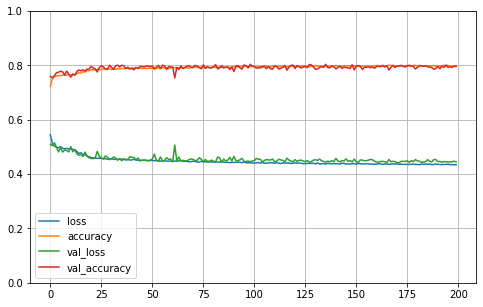

accuracy: 80.38%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5448 - accuracy: 0.7256 - val_loss: 0.5863 - val_accuracy: 0.7076
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5129 - accuracy: 0.7547 - val_loss: 0.5532 - val_accuracy: 0.7300
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5043 - accuracy: 0.7582 - val_loss: 0.4912 - val_accuracy: 0.7623
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4989 - accuracy: 0.7617 - val_loss: 0.4923 - val_accuracy: 0.7573
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4966 - accuracy: 0.7625 - val_loss: 0.5023 - val_accuracy: 0.7492
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4956 - accuracy: 0.7654 - val_loss: 0.5122 - val_accuracy: 0.7480
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4943 - accuracy: 0.76

Epoch 47/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4453 - accuracy: 0.7954 - val_loss: 0.4602 - val_accuracy: 0.7871
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4464 - accuracy: 0.7932 - val_loss: 0.4562 - val_accuracy: 0.7827
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4464 - accuracy: 0.7931 - val_loss: 0.4528 - val_accuracy: 0.7865
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4465 - accuracy: 0.7927 - val_loss: 0.4519 - val_accuracy: 0.7827
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4441 - accuracy: 0.7936 - val_loss: 0.4566 - val_accuracy: 0.7865
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4455 - accuracy: 0.7920 - val_loss: 0.4591 - val_accuracy: 0.7846
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4476 - accuracy: 0.7887 - val_loss: 0.4481 - val_accuracy:

Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.7967 - val_loss: 0.4618 - val_accuracy: 0.7815
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4375 - accuracy: 0.7989 - val_loss: 0.4503 - val_accuracy: 0.7840
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4400 - accuracy: 0.7971 - val_loss: 0.4509 - val_accuracy: 0.7902
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4378 - accuracy: 0.7965 - val_loss: 0.4465 - val_accuracy: 0.7883
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4383 - accuracy: 0.7959 - val_loss: 0.4452 - val_accuracy: 0.7902
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4381 - accuracy: 0.7963 - val_loss: 0.4461 - val_accuracy: 0.7883
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4372 - accuracy: 0.7989 - val_loss: 0.4552 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.4344 - accuracy: 0.8009 - val_loss: 0.4440 - val_accuracy: 0.7921
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4359 - accuracy: 0.7988 - val_loss: 0.4438 - val_accuracy: 0.7871
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4350 - accuracy: 0.7970 - val_loss: 0.4440 - val_accuracy: 0.7858
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4346 - accuracy: 0.7994 - val_loss: 0.4426 - val_accuracy: 0.7902
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4336 - accuracy: 0.8007 - val_loss: 0.4461 - val_accuracy: 0.7865
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4342 - accuracy: 0.8002 - val_loss: 0.4559 - val_accuracy: 0.7815
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.8003 - val_loss: 0.4447 - val_accuracy: 0.7902

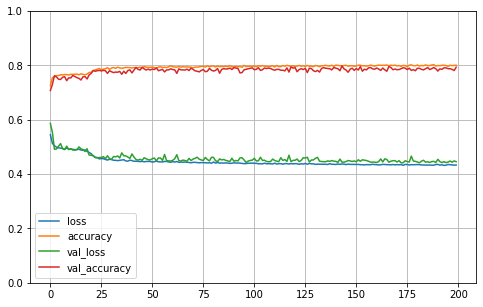

accuracy: 79.83%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5443 - accuracy: 0.7237 - val_loss: 0.5112 - val_accuracy: 0.7548
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5122 - accuracy: 0.7489 - val_loss: 0.4925 - val_accuracy: 0.7666
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5065 - accuracy: 0.7553 - val_loss: 0.4914 - val_accuracy: 0.7666
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5018 - accuracy: 0.7579 - val_loss: 0.4790 - val_accuracy: 0.7722
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5010 - accuracy: 0.7592 - val_loss: 0.4797 - val_accuracy: 0.7728
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4978 - accuracy: 0.7617 - val_loss: 0.4786 - val_accuracy: 0.7809
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4966 - accuracy: 0.76

Epoch 49/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4506 - accuracy: 0.7887 - val_loss: 0.4337 - val_accuracy: 0.8057
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4487 - accuracy: 0.7897 - val_loss: 0.4303 - val_accuracy: 0.8045
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4466 - accuracy: 0.7896 - val_loss: 0.4317 - val_accuracy: 0.8032
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4468 - accuracy: 0.7920 - val_loss: 0.4396 - val_accuracy: 0.8007
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4508 - accuracy: 0.7906 - val_loss: 0.4342 - val_accuracy: 0.8051
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4473 - accuracy: 0.7908 - val_loss: 0.4343 - val_accuracy: 0.7983
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4473 - accuracy: 0.7883 - val_loss: 0.4526 - val_accuracy:

Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4424 - accuracy: 0.7962 - val_loss: 0.4313 - val_accuracy: 0.8119
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4425 - accuracy: 0.7940 - val_loss: 0.4299 - val_accuracy: 0.8119
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4415 - accuracy: 0.7940 - val_loss: 0.4334 - val_accuracy: 0.8076
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4426 - accuracy: 0.7924 - val_loss: 0.4403 - val_accuracy: 0.8032
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4430 - accuracy: 0.7947 - val_loss: 0.4349 - val_accuracy: 0.8051
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4422 - accuracy: 0.7938 - val_loss: 0.4350 - val_accuracy: 0.8057
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4416 - accuracy: 0.7946 - val_loss: 0.4380 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.4396 - accuracy: 0.7969 - val_loss: 0.4282 - val_accuracy: 0.8070
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4393 - accuracy: 0.7940 - val_loss: 0.4306 - val_accuracy: 0.8125
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4381 - accuracy: 0.7945 - val_loss: 0.4328 - val_accuracy: 0.8051
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4383 - accuracy: 0.7942 - val_loss: 0.4301 - val_accuracy: 0.8113
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4373 - accuracy: 0.7977 - val_loss: 0.4267 - val_accuracy: 0.8088
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.7972 - val_loss: 0.4335 - val_accuracy: 0.8113
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4368 - accuracy: 0.7952 - val_loss: 0.4273 - val_accuracy: 0.8101

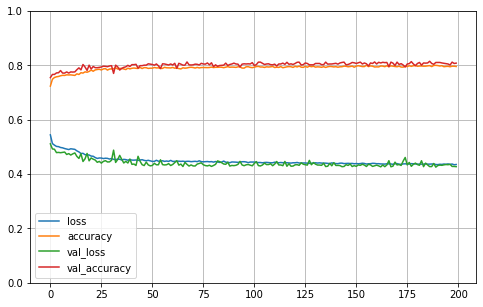

accuracy: 81.50%

5-way Cross Validation mean 80.50% (+/- 0.55%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")